In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Packages with tools for text processing.
import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import line_tokenize
from nltk.stem.snowball import SnowballStemmer

# Used for model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# Used to create value counts for EDA
from collections import Counter

# Using non-negative matrix factorization as unsupervised method
from sklearn.decomposition import NMF

# Used for label permutation of the unsupervised prediction
import itertools

# Used to random sampling of the data
import random

# Used to generate list of punctuations
import string

from wordcloud import WordCloud



# Problem Description

The WELFake_Dataset.csv from the Kaggle dataset [here](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification) contains 72,134 news articles with 3 columns: 
* title of the news article 
* text of the news articles
* label specifying whether the article is fake (label=0) or real (label=1)

The goal of this project is to leverage unsupervised learning to predict whether a news article is fake or real, and hopefully arrive at some insights that differentiate the two. We'll compare our unsupervised results to the labels for the dataset and see if we can optimize the model further using the accuracy scores.

Github Repo- [here](https://github.com/cfildish/CU_AI/tree/main/CSCA_5632_Unsupervised_Learning)

# Data Ingest and Transformation

#### Data Ingest

In [21]:
df = pd.read_csv("WELFake_Dataset.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [22]:
# Check NaN values
print(f"Total titles: {len(df)}")
print()
df.isna().sum()

Total titles: 72134



title    558
text      39
label      0
dtype: int64

Because the NaN values are low relative to the length of the dataframe, drop them.

In [23]:
df = df.dropna()

This was modeled on a laptop and the dataset is large (~72k articles!), which made for very slow data transformation and modeling (including one laptop crash). For this reason, the first 5k from each label is extracted into a smaller dataframe, which allows for more model tuning and optimization.

In [45]:
fake_df = df.loc[df["label"] == 0].reset_index().drop(columns=["index"]).iloc[0:5000]
real_df = df.loc[df["label"] == 1].reset_index().drop(columns=["index"]).iloc[0:5000]

model_df = pd.concat([fake_df, real_df], axis=0)
model_df[["label"]].value_counts()



label
0        5000
1        5000
dtype: int64

#### Data Transformation

Data Cleaning Procedures:
1. Tokenize each of the messages
2. For each message:
    * expand contractions (two words combined into one with an apostraphe) into two words
    * convert the words to lower case
    * remove stop words and punctuation
    * stem the words using the snowballstemmer (an updated version of Porter stemmer)
3. Join the converted messages back into a string and create a document term matrix and TF-IDF DTM for the data.

In [46]:
# Contraction map
c_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", 
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
    "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will",
    "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will", 
    "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had",
    "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are",
    "you've": "you have"
}


In [103]:
# Updates individual messages for feature matrix
def message_convert(message, stop_words, punc):
    # 1. if the word has a leading hashtag, remove it
    # 2. convert words to lower case
    # 3. remove stop words, punctuation and non-alphabetical characters
    # 4. stem words
    converted_list = []
    for word in message:
        if word in c_dict:
            words = c_dict[word].split(" ")
            for c_word in words:
                if c_word not in stop_words and c_word.isalpha:
                    converted_list.append(SnowballStemmer('english').stem(c_word.lower()))
            continue
        if word not in stop_words and word not in punc and word.isalpha:
            converted_list.append(SnowballStemmer('english').stem(word.lower()))
    return converted_list
    
def process_text_data(df, column="text"):
    stop_words = stopwords.words('english')
    stop_words.extend(["say", "said", "like", "come", "go", "take", "want", "need", "use", "make", "sinc",
                       "one", "two"])
    punc = list(set(string.punctuation))
    
    # tokenization- split each message into words
    chat_messages = [nltk.word_tokenize(message) for message in df[column]]

    # clean individual messages
    cleaned_chat_messages = [message_convert(message, stop_words, punc) for message in chat_messages]

    # Join words in each message back into a single character string.
    # cleaned_chat_messages_string = [' '.join(message) for message in cleaned_chat_messages]
    
    return cleaned_chat_messages

cleaned_chat_messages_text = process_text_data(model_df)
cleaned_chat_messages_title = process_text_data(model_df, column="title")
 

In [104]:
model_df["processed_text"] = cleaned_chat_messages_text
model_df["processed_title"] = cleaned_chat_messages_title
model_df["processed_all"] = model_df["processed_text"]+model_df["processed_title"]
model_df.head()


,title,text,label,processed_text,processed_title,processed_all
0,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[a, dozen, polit, activ, pastor, came, privat,...","[bobbi, jindal, rais, hindu, use, stori, chris...","[a, dozen, polit, activ, pastor, came, privat,..."
1,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0,"[brussel, reuter, british, prime, minist, ther...","[may, brexit, offer, would, hurt, cost, eu, ci...","[brussel, reuter, british, prime, minist, ther..."
2,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0,"[washington, reuter, charl, schumer, top, demo...","[schumer, call, trump, appoint, offici, overse...","[washington, reuter, charl, schumer, top, demo..."
3,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,"[as, sport, fan, turn, espn, protest, network,...","[no, chang, expect, espn, polit, agenda, despi...","[as, sport, fan, turn, espn, protest, network,..."
4,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0,"[rio, de, janeiro/sao, paulo, reuter, billiona...","[billionair, odebrecht, brazil, scandal, relea...","[rio, de, janeiro/sao, paulo, reuter, billiona..."


In [50]:
pickle.dump(df, open("processed_data.sav", "wb"))
# df = pickle.load(open("processed_data.sav", "rb"))

Document Term Matrices for the Text, Title, and combined columns- used for EDA

In [93]:
## Processed Text
# Initialize `CountVectorizer`.
vec = CountVectorizer(preprocessor=' '.join, 
                      stop_words="english")

# Transform the list of chat messages into DTM
X = vec.fit_transform(model_df["processed_text"])
# Convert the matrix into a pandas dataframe for easier manipulation.
DTM_text = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())


## Processed Title
# Transform the list of chat messages into DTM
X = vec.fit_transform(model_df["processed_title"])
# Convert the matrix into a pandas dataframe for easier manipulation.
DTM_title = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())

## Processed Combination of title and text
# Transform the list of chat messages into DTM
X = vec.fit_transform(model_df["processed_all"])
# Convert the matrix into a pandas dataframe for easier manipulation.
DTM_all = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())


# EDA

### Histogram of Number of Words

#### Text

Minimum word count message: 1
Maximum word count message: 18610


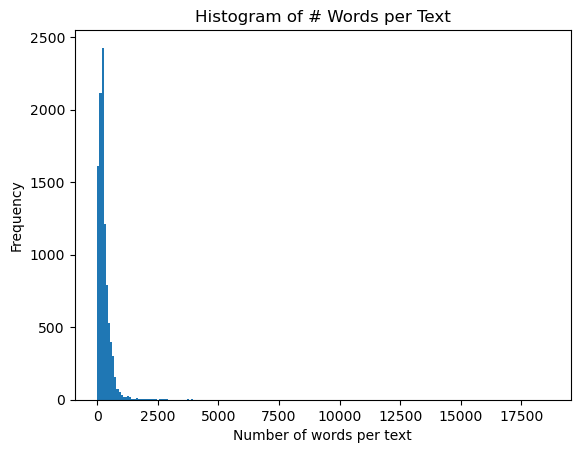

In [79]:
word_counts_per_message = np.array(DTM_text.sum(axis=1))
print(f"Minimum word count message: {min(word_counts_per_message)}")
print(f"Maximum word count message: {max(word_counts_per_message)}")

plt.hist(word_counts_per_message, bins = int(len(set(word_counts_per_message))/5))
plt.xlabel('Number of words per text')
plt.title("Histogram of # Words per Text")
plt.ylabel('Frequency')
plt.show()



Overall, the number of words in each article is highly skewed right with a few outlier articles with a very high word count. This will likely make the TF-IDF transformer a good candidate for modeling because it reduces the weight of large-word documents so they aren't more influential than smaller documents.

#### Title

Minimum word count message: 0
Maximum word count message: 29


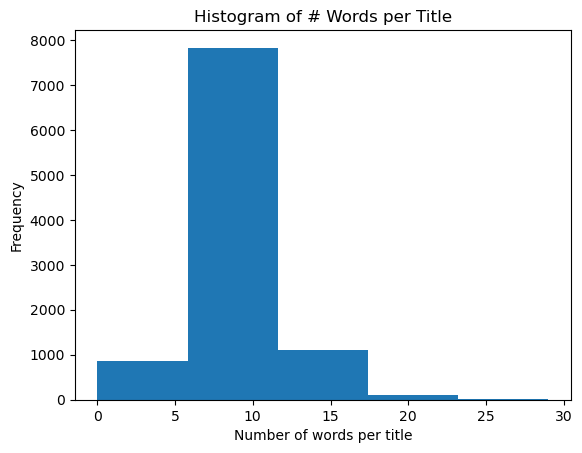

In [80]:
word_counts_per_message = np.array(DTM_title.sum(axis=1))
print(f"Minimum word count message: {min(word_counts_per_message)}")
print(f"Maximum word count message: {max(word_counts_per_message)}")

plt.hist(word_counts_per_message, bins = int(len(set(word_counts_per_message))/5))
plt.xlabel('Number of words per title')
plt.title("Histogram of # Words per Title")
plt.ylabel('Frequency')
plt.show()


### Cleaned Message Word Counts Sorted by Most to Least Frequent

#### Text

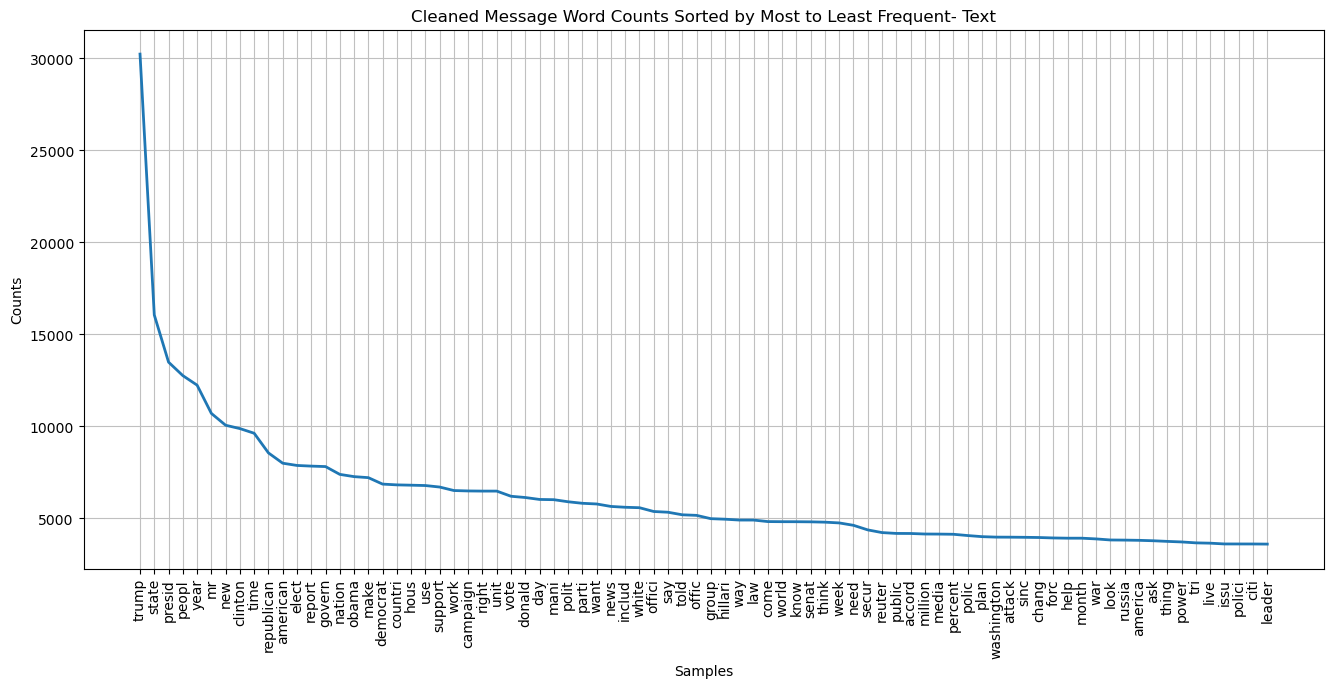

In [81]:
# Create dictionary of total word counts
corpus_freq_dist = DTM_text.sum(axis = 0).to_dict()

# Save as a FreqDist object native to nltk.
corpus_freq_dist = nltk.FreqDist(corpus_freq_dist)
# Plot distribution for the entire corpus.
plt.figure(figsize = (16, 7))
plt.title("Cleaned Message Word Counts Sorted by Most to Least Frequent- Text")
corpus_freq_dist.plot(80)
plt.show()

#### Title

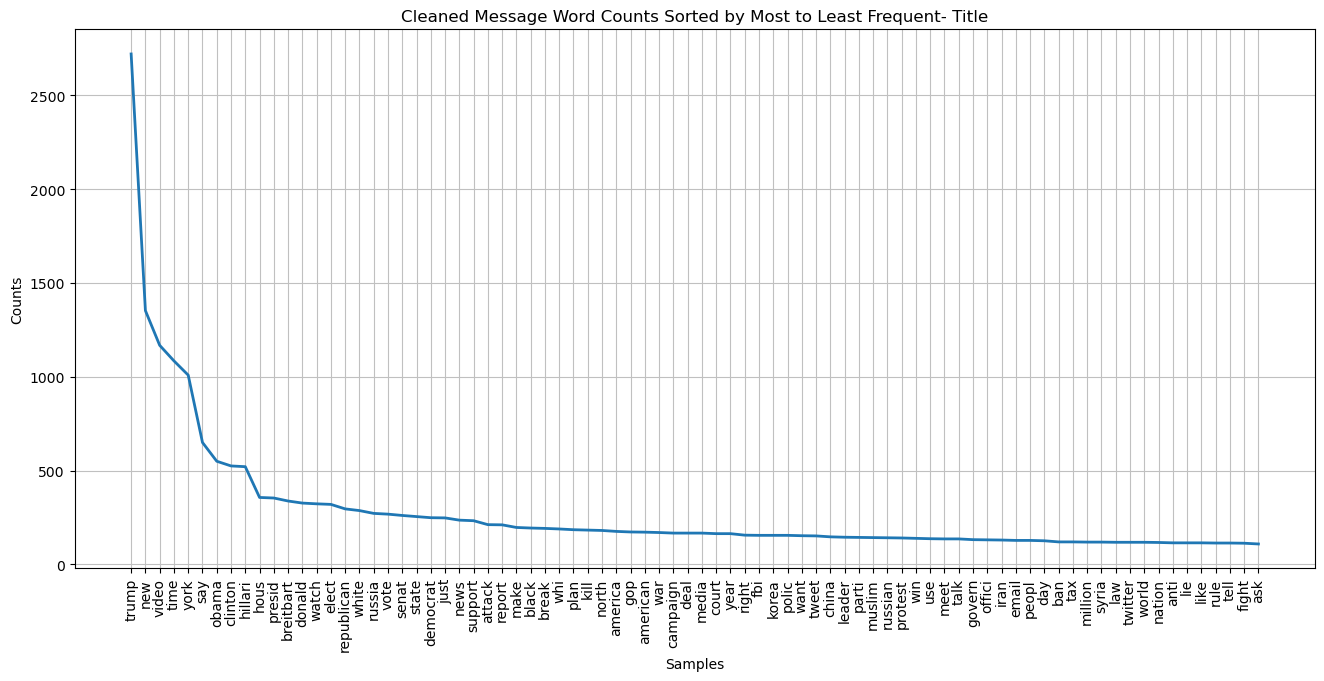

In [82]:
# Create dictionary of total word counts
corpus_freq_dist = DTM_title.sum(axis = 0).to_dict()

# Save as a FreqDist object native to nltk.
corpus_freq_dist = nltk.FreqDist(corpus_freq_dist)
# Plot distribution for the entire corpus.
plt.figure(figsize = (16, 7))
plt.title("Cleaned Message Word Counts Sorted by Most to Least Frequent- Title")
corpus_freq_dist.plot(80)
plt.show()


### WordClouds for Real and Fake Articles


#### Real

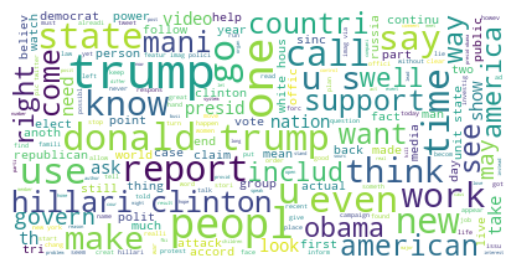

In [100]:
real_article_df = model_df.loc[model_df["label"]==1].copy()
cleaned_chat_messages_string = [' '.join(message) for message in real_article_df["processed_all"]]

# Construct a word cloud from corpus.
wordcloud = WordCloud(max_font_size = 40, background_color = "white")
wordcloud = wordcloud.generate(' '.join(cleaned_chat_messages_string))

# Plot the cloud using matplotlib.
plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


#### Fake

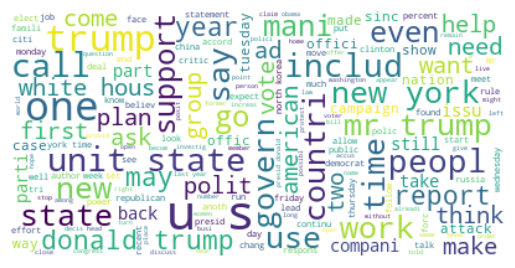

In [101]:
real_article_df = model_df.loc[model_df["label"]==0].copy()
cleaned_chat_messages_string = [' '.join(message) for message in real_article_df["processed_all"]]

# Construct a word cloud from corpus.
wordcloud = WordCloud(max_font_size = 40, background_color = "white")
wordcloud = wordcloud.generate(' '.join(cleaned_chat_messages_string))

# Plot the cloud using matplotlib.
plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


Based on the wordclouds for the real and fake articles, it appears that the some of the most common words in real and fake articles are shared. For the transformation we use for modeling, we'll need to make sure we remove the words the appear in most articles and also remove words that appear in only a handful of articles. Without removing those edge cases, it would be more difficult for clustering methods to distinguish between article types.

Another thing we address based on the wordclouds is there appear to be words such as "want", "sinc", and "use" which aren't very informative, so before modeling some of these additional words are removed.

#### Plan of Analysis

After removing stop words, the distribution of words in the corpus is still highly skewed right as well as the number of words per article, in particular for the text of the article. For that reason TF-IDF is used to transform the data which helps to adjust for the fact that some words appear more frequently in general. TF-IDF also eliminates the size effect of documents so larger-word documents no longer have a larger influence compared to smaller-word documents. For matrix factorization, I'll start by using non-negative matrix factorization because it’s typically well suited for data with non-zero entries such as word count in this case.

# Unsupervised Modeling

TF-IDF Tranformer Used for Modeling

In [123]:
# ignore words that appear in more than 90% of the articles or in less than 10% of the articles
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.05,
    max_df=0.95,
    ngram_range=(1, 2),
    preprocessor=' '.join, 
    stop_words="english"
)

tfidf_text = tfidf_vectorizer.fit_transform(model_df["processed_text"])
tfidf_text_DTM = pd.DataFrame(tfidf_text.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

tfidf_title = tfidf_vectorizer.fit_transform(model_df["processed_title"])
tfidf_title_DTM = pd.DataFrame(tfidf_title.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

tfidf_all = tfidf_vectorizer.fit_transform(model_df["processed_all"])
tfidf_all_DTM = pd.DataFrame(tfidf_all.toarray(), columns = tfidf_vectorizer.get_feature_names_out())



In [107]:
def label_permute_compare(ytdf,yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """     
    all_permutations = list(itertools.permutations(list(range(n))))
    
    best_accuracy = -1000
    for p in all_permutations:
        ytarray = np.array(ytdf)
        for i in range(len(ytdf.unique())):
            ytarray[ytarray == ytdf.unique()[i]] = list(p)[i]
        accuracy = accuracy_score(list(ytarray), list(yp))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_p = p
        
    return best_p, best_accuracy


## Base Model

### Method 1- Concatenate the Processed Texts for title and article into combined

In [127]:
n_categories = len(model_df["label"].unique())

model = NMF(n_components=n_categories, init='random', random_state=0)
W = model.fit_transform(tfidf_all)
H = model.components_

labels_num = W.argmax(axis=1)



In [128]:
best_p, best_accuracy = label_permute_compare(model_df["label"], labels_num)

mapping = {}
for i in range(len(best_p)):
    mapping[best_p[i]]= list(model_df["label"].unique())[i]

labels = [mapping.get(item, item) for item in list(labels_num)]

print(f"First 10 labels: {labels[0:10]}")
print()
print(f"Accuracy for Base Model: {best_accuracy}")
print()
print("Confusion Matrix for Base Model")
print(confusion_matrix(model_df["label"], labels))


First 10 labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Accuracy for Base Model: 0.4055802668823292

Confusion Matrix for Base Model
[[1156 3843]
 [2037 2856]]


### Method 2- Model for the text and title individually, then combine

In [115]:
n_categories = len(model_df["label"].unique())

model = NMF(n_components=n_categories, init='random', random_state=0)
W_text = model.fit_transform(tfidf_text)
H_text = model.components_

labels_num = W.argmax(axis=1)

model = NMF(n_components=n_categories, init='random', random_state=0)
W_title = model.fit_transform(tfidf_title)
H_title = model.components_

W = W_title+W_text
labels_num = W.argmax(axis=1)


In [116]:
best_p, best_accuracy = label_permute_compare(model_df["label"], labels_num)

mapping = {}
for i in range(len(best_p)):
    mapping[best_p[i]]= list(model_df["label"].unique())[i]

labels = [mapping.get(item, item) for item in list(labels_num)]

print(f"First 10 labels: {labels[0:10]}")
print()
print(f"Accuracy for Base Model: {best_accuracy}")
print()
print("Confusion Matrix for Base Model")
print(confusion_matrix(model_df["label"], labels))


First 10 labels: [1, 1, 1, 1, 1, 1, 1, 0, 1, 0]

Accuracy for Base Model: 0.5615649009300445

Confusion Matrix for Base Model
[[1474 3525]
 [ 812 4081]]


The base models performed very poorly, in particular for classifying fake articles correctly as seen in the top row of the confusion matrix. Given we're using unsupervised learning which has no awareness of the known labels, it's possible that the two groupings created by the model have nothing to do with fake or real- for example what if the unsupervised model split articles into political vs non-political as opposed to fake or real?

#### Plot the words for each predicted grouping to see if we can identify how it's splitting the data.

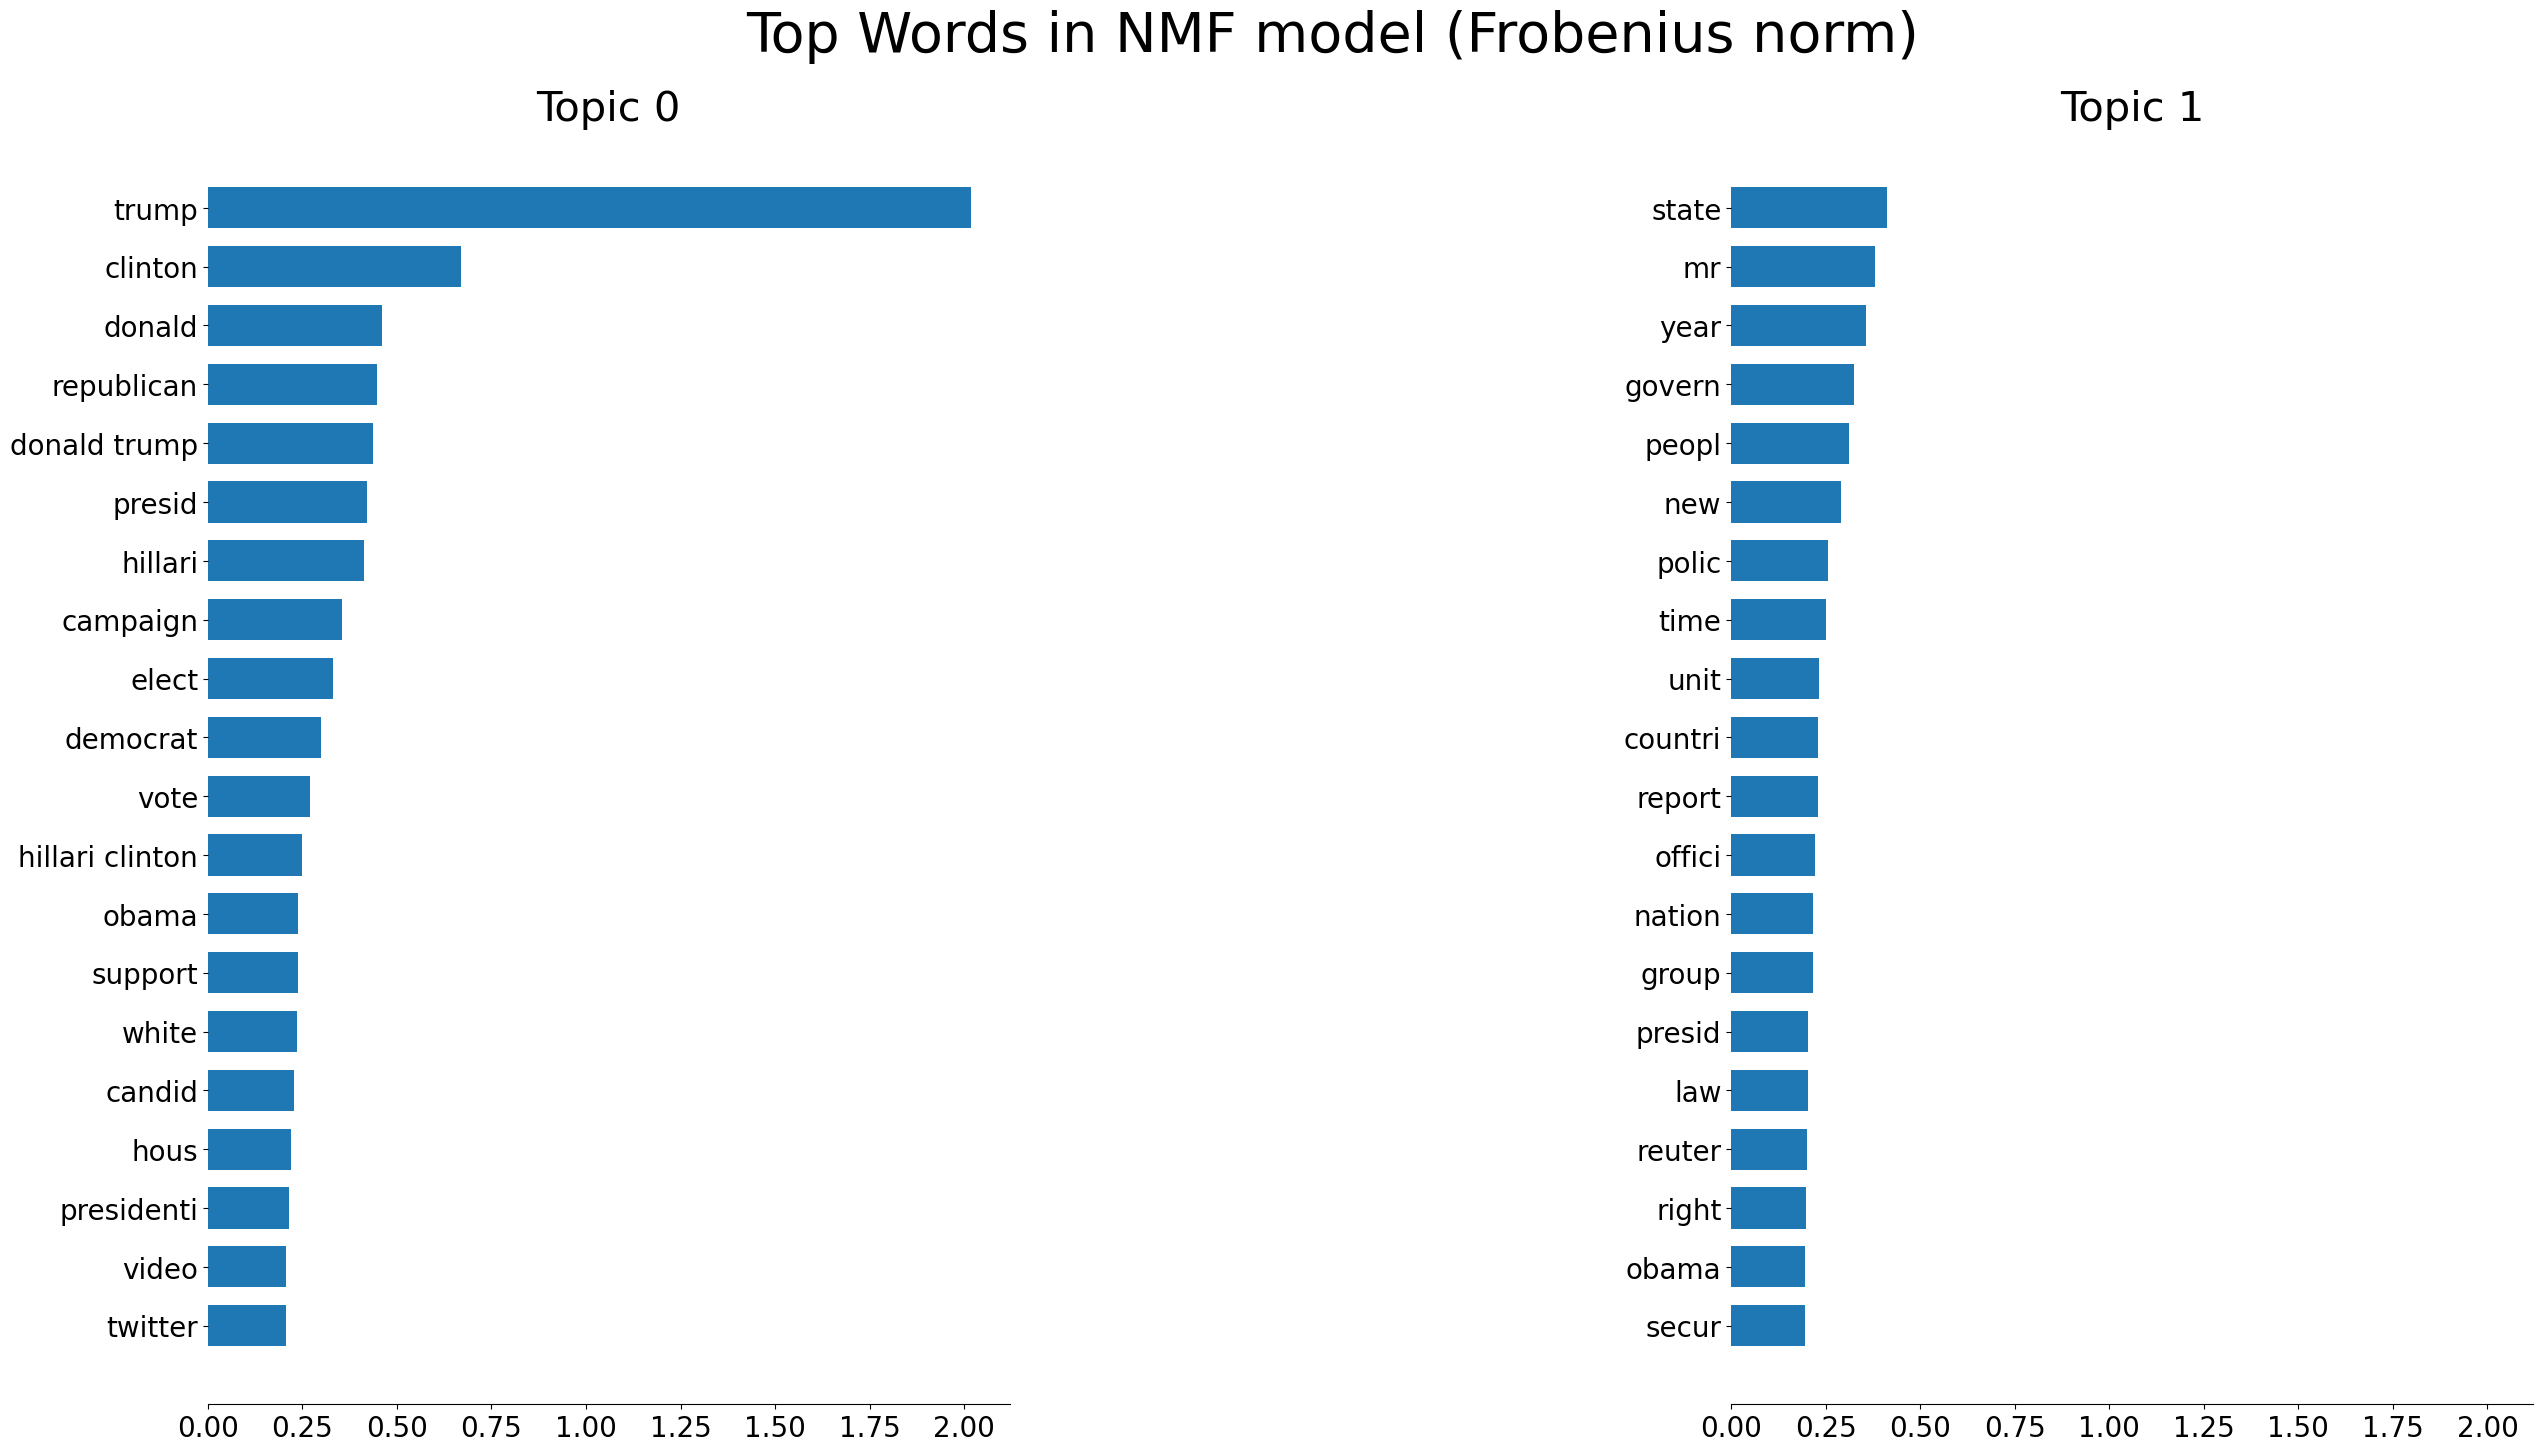

In [126]:
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title, best_p, model_df):
    fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {list(model_df['label'].unique())[best_p[topic_idx]]}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
tfidf_feature_names = tfidf_all_DTM.columns
plot_top_words(
    model, tfidf_feature_names, n_top_words, "Top Words in NMF model (Frobenius norm)", best_p, model_df
)


As suspected, based on the accuracies of the unsupervised models (the words and word clouds used in the EDA process also alluded to this), the split determined by the unsupervised model doesn't look like it split based on real or fake articles. Instead, it seems to have split based on if the article mentions Trump in the article or not.

We can confirm this by checking the accuracy score of the predicted labels of the unsupervised model with a boolean for if Trump appears in the article, which we can see performs much better

In [134]:
includes_trump = [0 if "trump" in row["processed_all"] else 1 for index, row in model_df.iterrows()]
print(accuracy_score(includes_trump, labels))


0.8012535382126972


Two ways I can think of to address this are:

* remove all instances of the word "trump" for articles to force the unsupervised model to hopefully create new types of categories or 
* split the input data into data that includes trump in the article or title vs data that doesn't, and run their models separately. 

We try the latter method below

### Re-run creating one unsupervised model for data that includes "trump" vs data that doesn't

In [138]:
model_df["includes_trump"] = [0 if "trump" in row["processed_all"] else 1 for index, row in model_df.iterrows()]

trump_df = model_df.loc[model_df["includes_trump"] == 0].copy()

print(f"Length of Trump DF- {len(trump_df)}")
print(f"Number of Real Articles- {trump_df['label'].sum()}")

non_trump_df = model_df.loc[model_df["includes_trump"] == 1].copy()

print()
print(f"Length of Non-Trump DF- {len(non_trump_df)}")
print(f"Number of Real Articles- {non_trump_df['label'].sum()}")


Length of Trump DF- 4489
Number of Real Articles- 2308

Length of Non-Trump DF- 5403
Number of Real Articles- 2585


#### Start with only the Articles/Titles that Include Trump

In [139]:
# ignore words that appear in more than 90% of the articles or in less than 10% of the articles
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.05,
    max_df=0.95,
    ngram_range=(1, 2),
    preprocessor=' '.join, 
    stop_words="english"
)

tfidf_text = tfidf_vectorizer.fit_transform(trump_df["processed_text"])
tfidf_text_DTM = pd.DataFrame(tfidf_text.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

tfidf_title = tfidf_vectorizer.fit_transform(trump_df["processed_title"])
tfidf_title_DTM = pd.DataFrame(tfidf_title.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

tfidf_all = tfidf_vectorizer.fit_transform(trump_df["processed_all"])
tfidf_all_DTM = pd.DataFrame(tfidf_all.toarray(), columns = tfidf_vectorizer.get_feature_names_out())


In [140]:
n_categories = len(trump_df["label"].unique())

model = NMF(n_components=n_categories, init='random', random_state=0)
W = model.fit_transform(tfidf_all)
H = model.components_

labels_num = W.argmax(axis=1)


In [144]:
best_p, best_accuracy = label_permute_compare(trump_df["label"], labels_num)

mapping = {}
for i in range(len(best_p)):
    mapping[best_p[i]]= list(trump_df["label"].unique())[i]

labels = [mapping.get(item, item) for item in list(labels_num)]

print(f"First 10 labels: {labels[0:10]}")
print()
# print(f"Accuracy for Base Model: {best_accuracy}")
print(f"Accuracy for Base Model: {accuracy_score(trump_df['label'], labels)}")
print()
print("Confusion Matrix for Base Model")
print(confusion_matrix(trump_df["label"], labels))


First 10 labels: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Accuracy for Base Model: 0.7518378257963911

Confusion Matrix for Base Model
[[1680  501]
 [ 613 1695]]


The score looks much better!

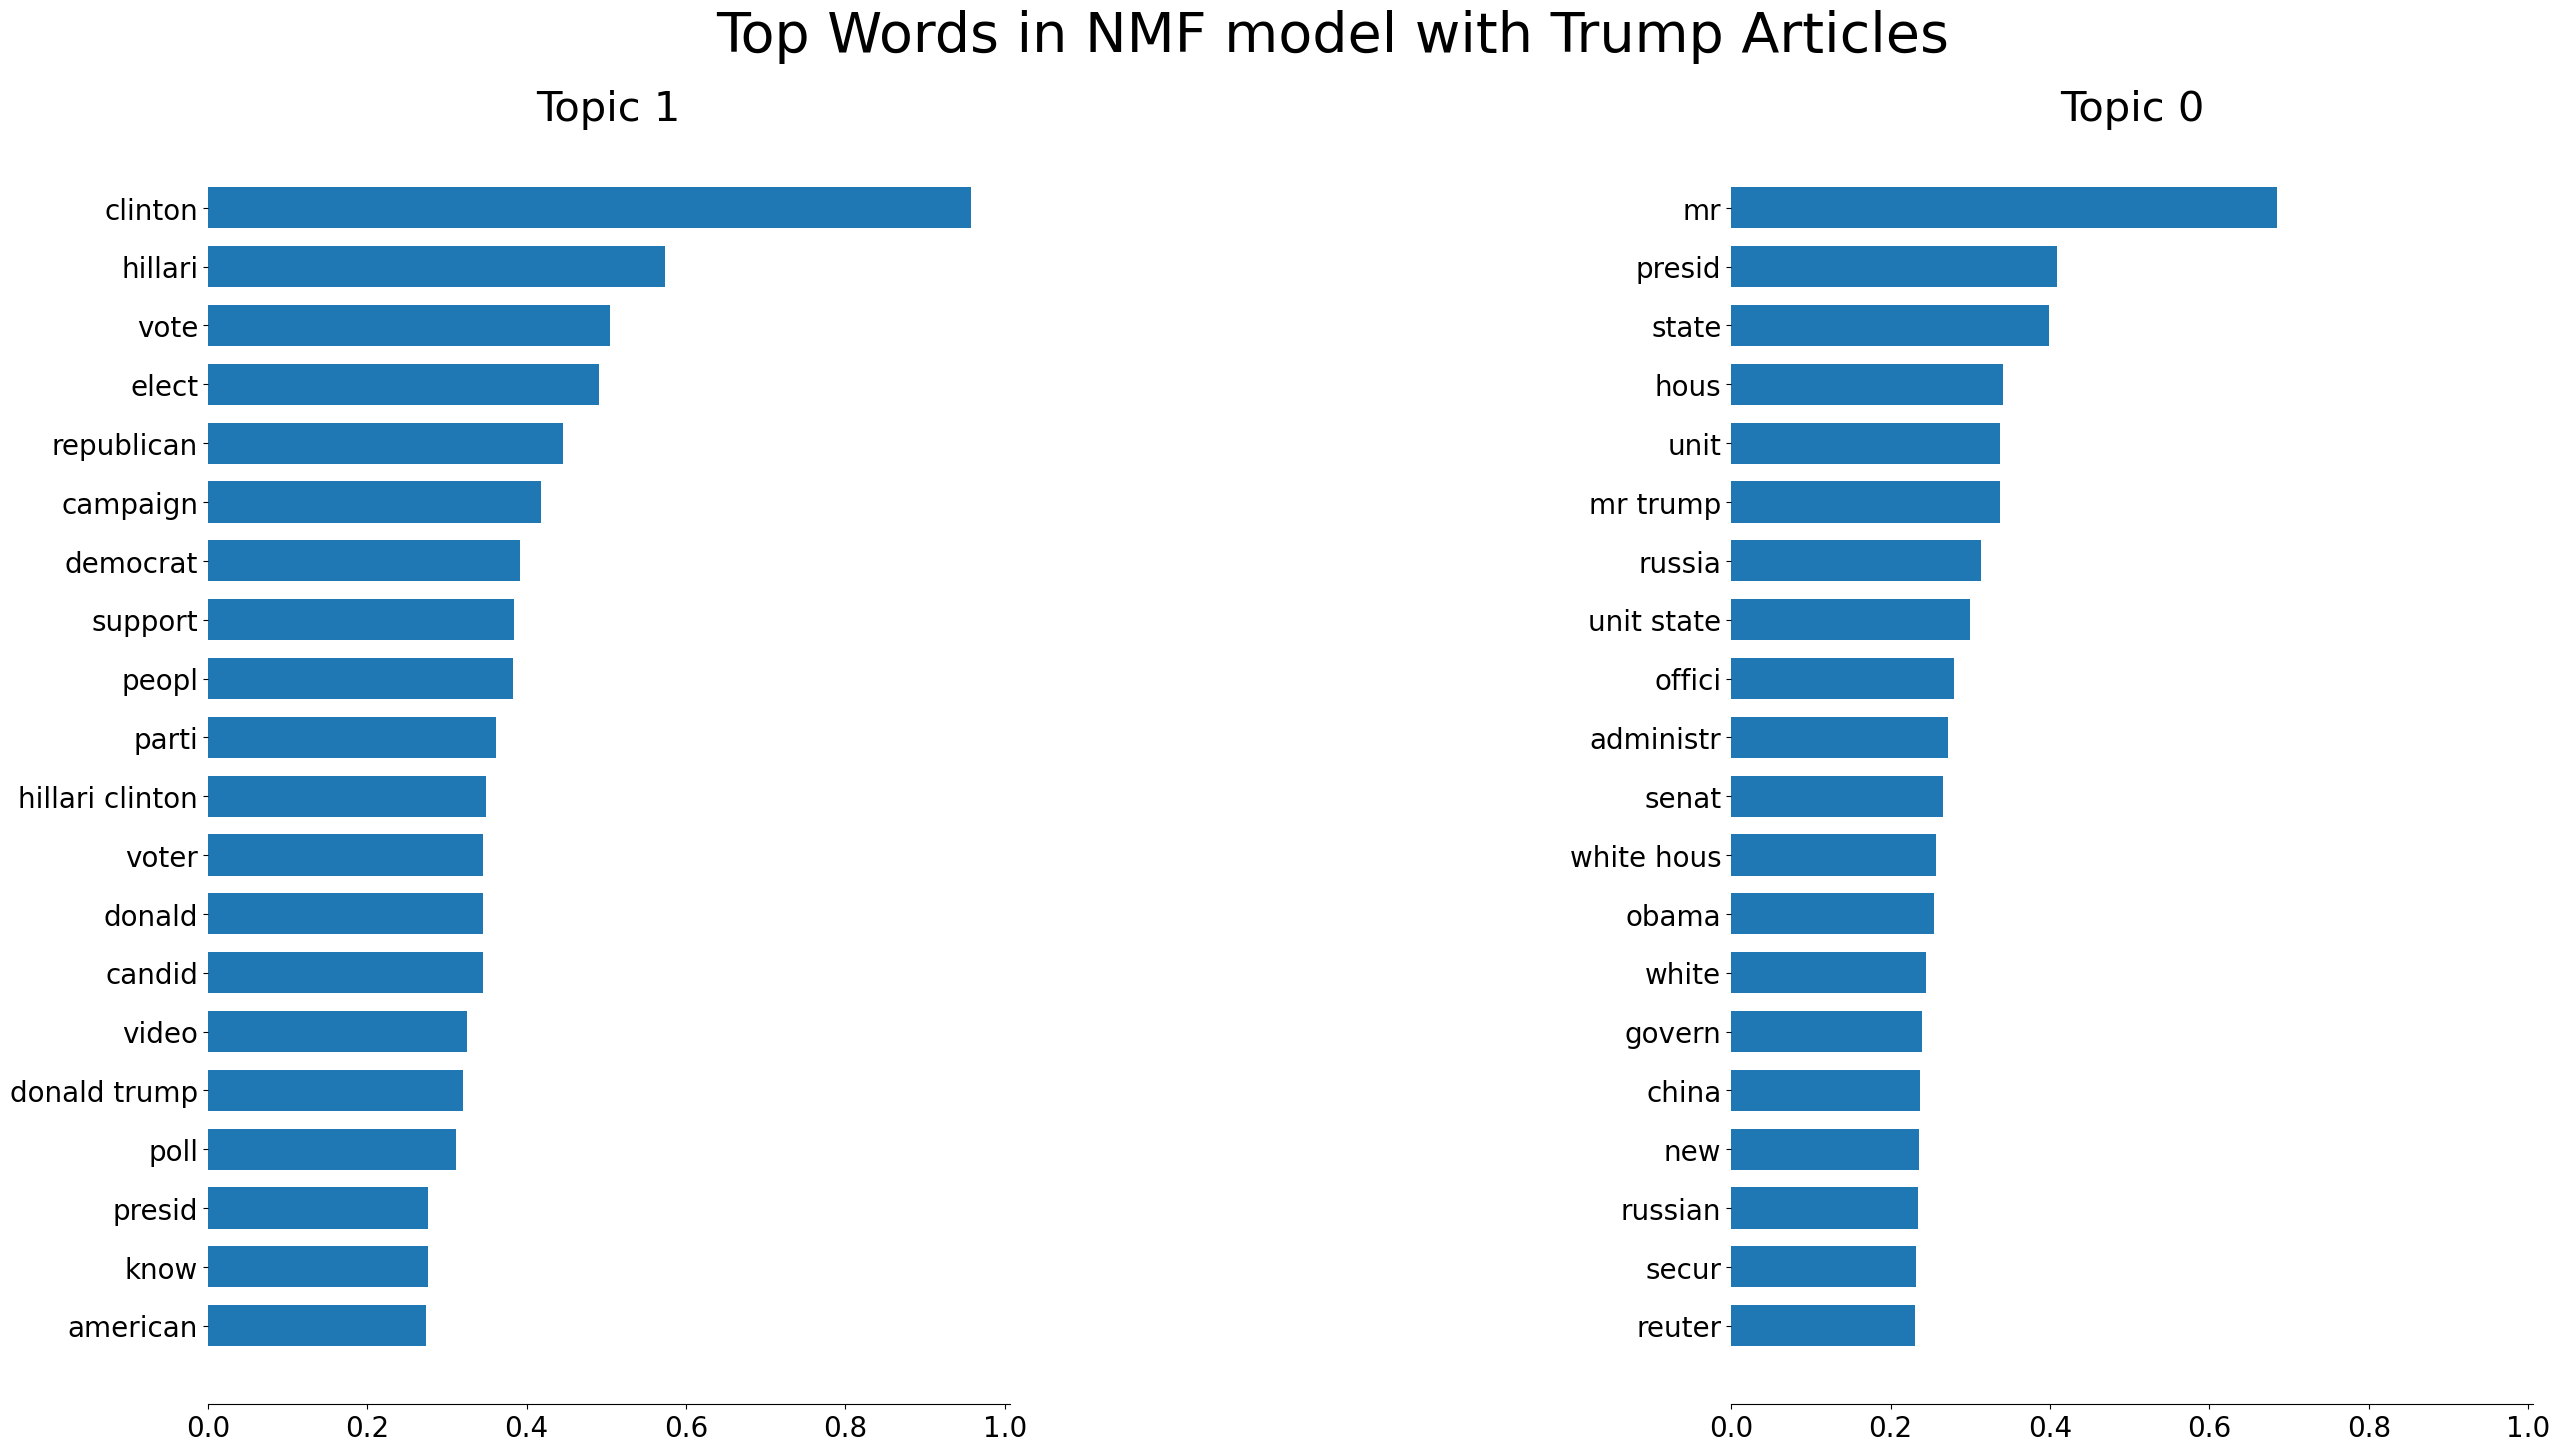

In [146]:
tfidf_feature_names = tfidf_all_DTM.columns
plot_top_words(
    model, tfidf_feature_names, n_top_words, "Top Words in NMF model with Trump Articles", best_p, trump_df
)

#### Now check Articles/Titles that Don't Include Trump

In [147]:
# ignore words that appear in more than 90% of the articles or in less than 10% of the articles
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.05,
    max_df=0.95,
    ngram_range=(1, 2),
    preprocessor=' '.join, 
    stop_words="english"
)

tfidf_text = tfidf_vectorizer.fit_transform(non_trump_df["processed_text"])
tfidf_text_DTM = pd.DataFrame(tfidf_text.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

tfidf_title = tfidf_vectorizer.fit_transform(non_trump_df["processed_title"])
tfidf_title_DTM = pd.DataFrame(tfidf_title.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

tfidf_all = tfidf_vectorizer.fit_transform(non_trump_df["processed_all"])
tfidf_all_DTM = pd.DataFrame(tfidf_all.toarray(), columns = tfidf_vectorizer.get_feature_names_out())


In [148]:
n_categories = len(non_trump_df["label"].unique())

model = NMF(n_components=n_categories, init='random', random_state=0)
W = model.fit_transform(tfidf_all)
H = model.components_

labels_num = W.argmax(axis=1)


In [149]:
best_p, best_accuracy = label_permute_compare(non_trump_df["label"], labels_num)

mapping = {}
for i in range(len(best_p)):
    mapping[best_p[i]]= list(non_trump_df["label"].unique())[i]

labels = [mapping.get(item, item) for item in list(labels_num)]

print(f"First 10 labels: {labels[0:10]}")
print()
# print(f"Accuracy for Base Model: {best_accuracy}")
print(f"Accuracy for Base Model: {accuracy_score(non_trump_df['label'], labels)}")
print()
print("Confusion Matrix for Base Model")
print(confusion_matrix(non_trump_df["label"], labels))


First 10 labels: [1, 0, 1, 0, 0, 0, 0, 1, 1, 0]

Accuracy for Base Model: 0.6235424764019989

Confusion Matrix for Base Model
[[1571 1247]
 [ 787 1798]]


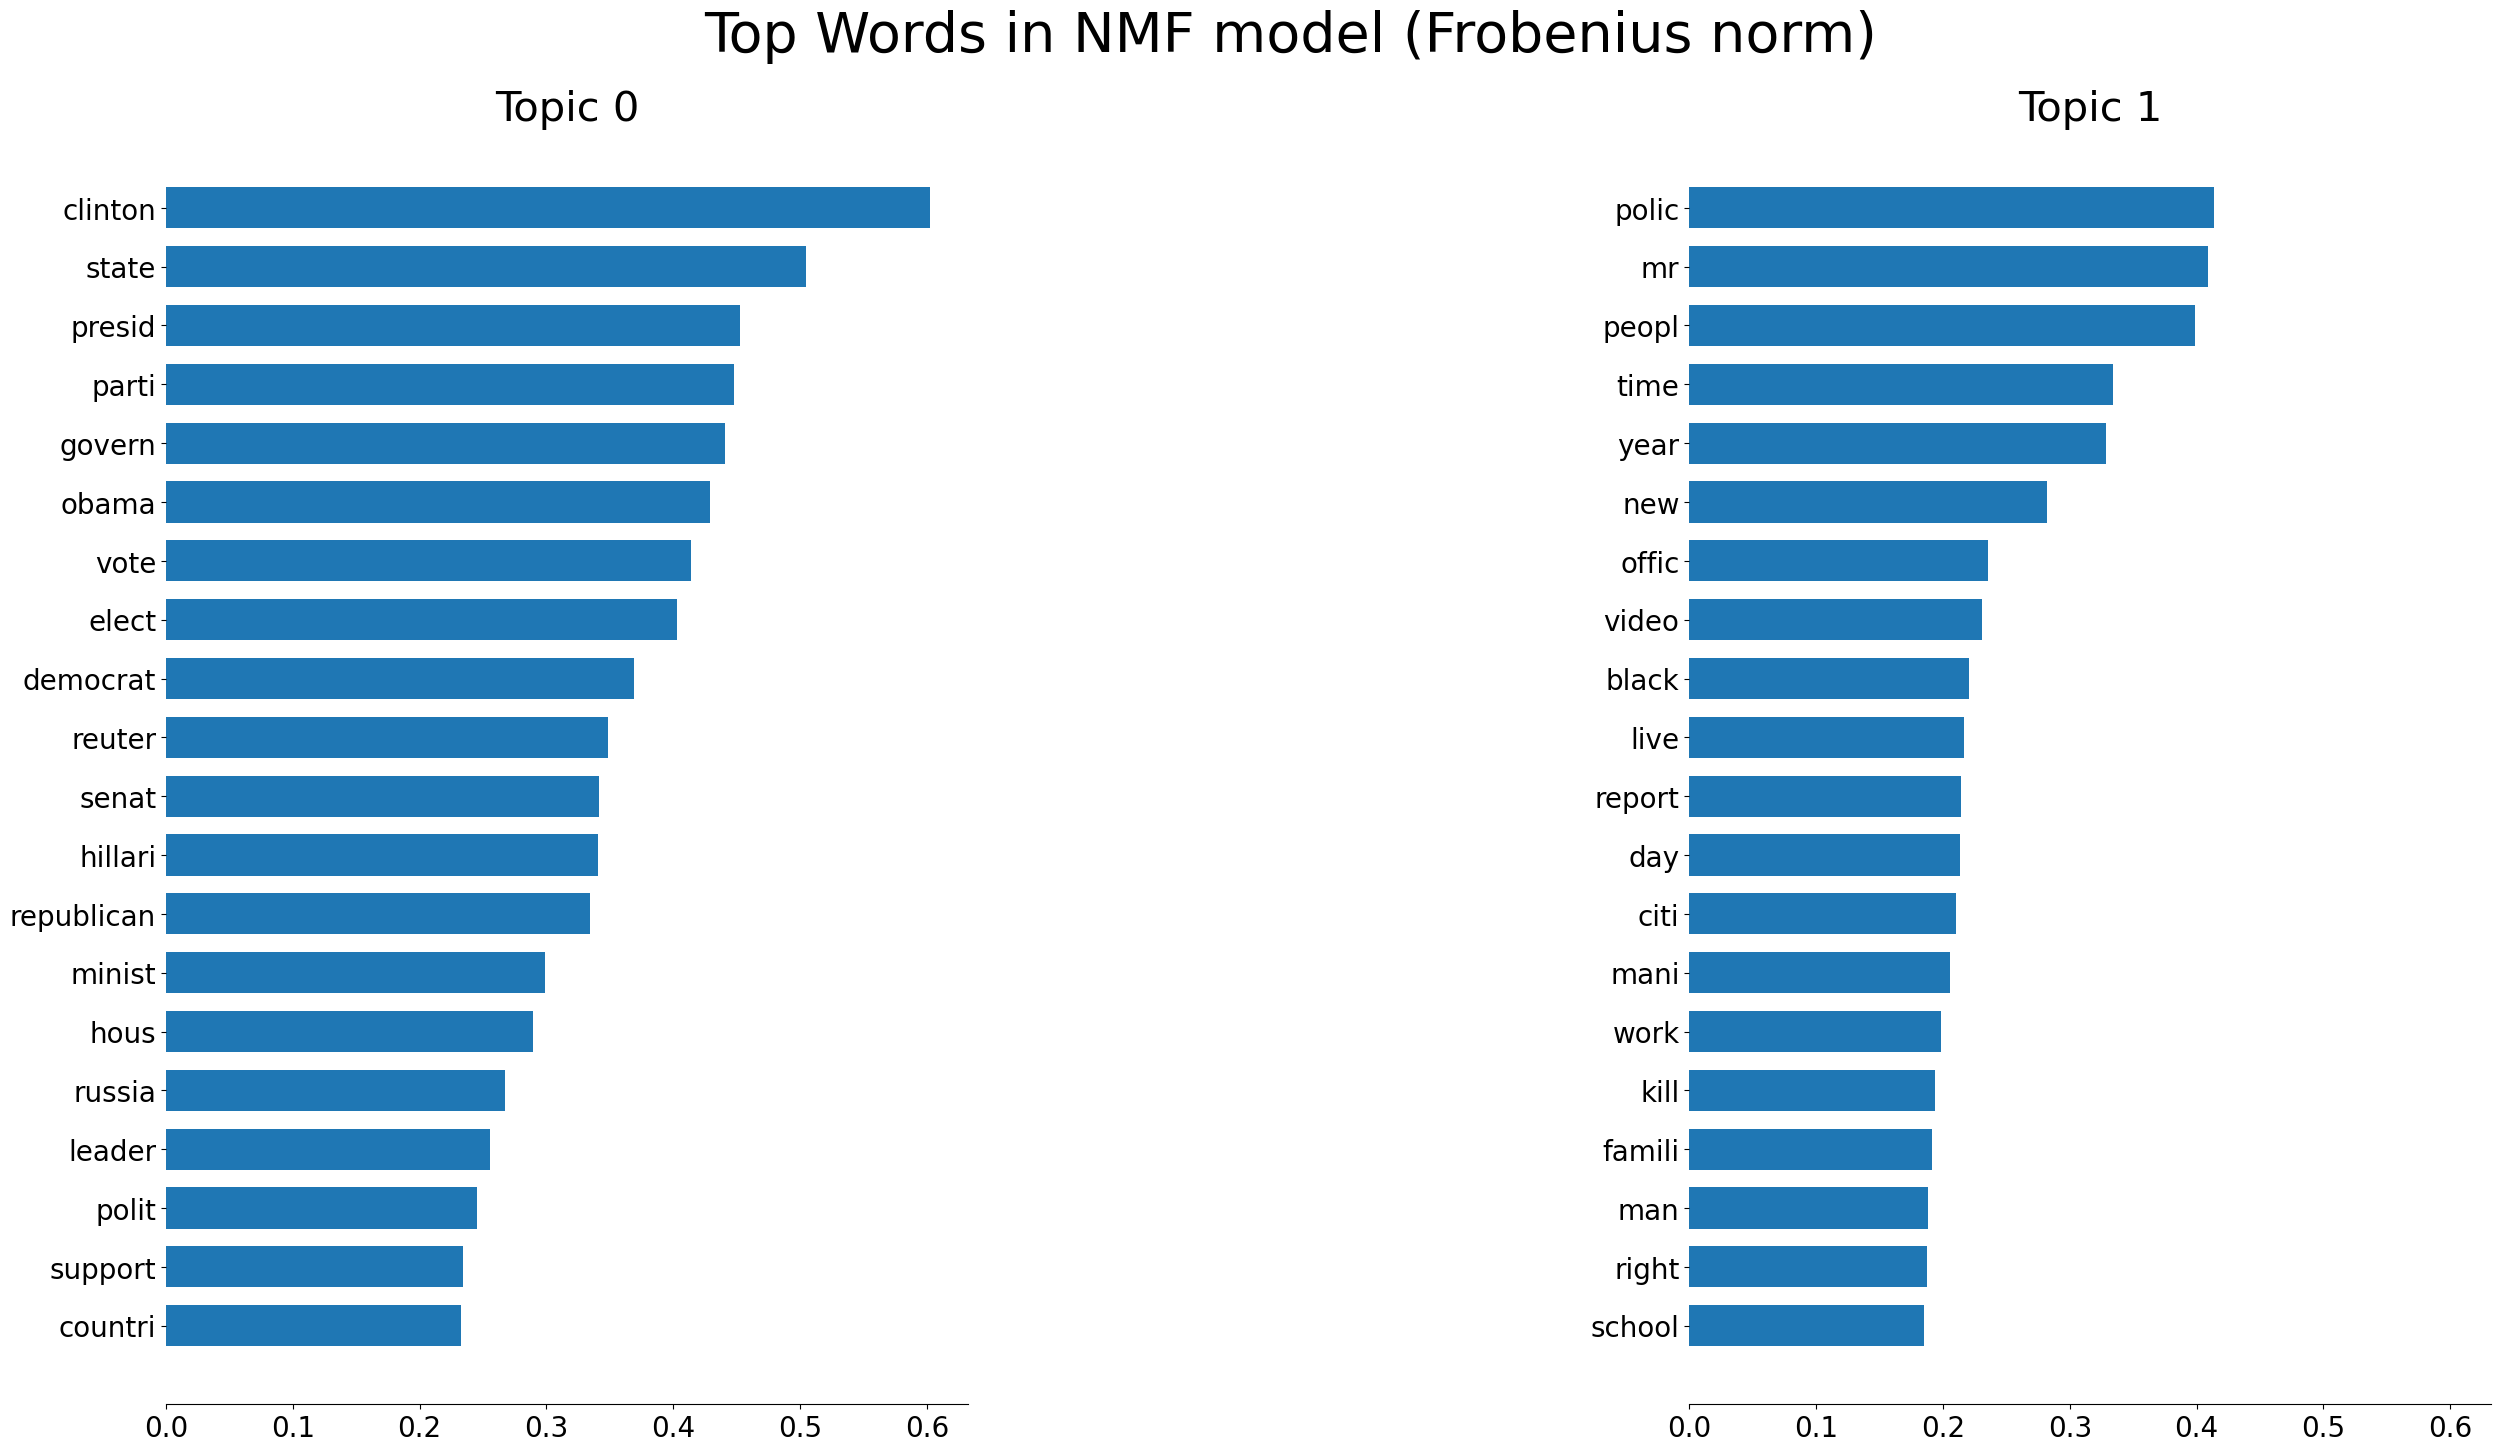

In [150]:
tfidf_feature_names = tfidf_all_DTM.columns
plot_top_words(
    model, tfidf_feature_names, n_top_words, "Top Words in NMF model (Frobenius norm)", best_p, non_trump_df
)


## Compare to Supervised Learning Model using the same Input Data

In [152]:
# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ignore words that appear in more than 90% of the articles or in less than 10% of the articles
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.05,
    max_df=0.95,
    ngram_range=(1, 2),
    preprocessor=' '.join, 
    stop_words="english"
)

tfidf_all = tfidf_vectorizer.fit_transform(model_df["processed_all"])
tfidf_all_DTM = pd.DataFrame(tfidf_all.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(tfidf_all_DTM, model_df["label"], test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_pred, y_test))


0.9433962264150944


It's not surprising that the supervised learning method with random forests performed much better compared to non-negative matrix factorization. The unsupervised NMF model was told to generate the two groupings with the highest seperability regardless of whether it related to the class label, while the supervised method was fit using the labels specifying fake vs real.

# Result

Let's check the weighted accuracy of our two split models:

In [151]:
overall_accuracy = (0.7518378257963911*len(trump_df)+0.6235424764019989*len(non_trump_df))/len(model_df)
print(overall_accuracy)


0.6817630408410837


The overall accuracy of the model improved when the models for articles that included Trump were independent of articles the didn't. Specifically the model attempting to split fake or real articles for the articles including Trump performed relatively well, so the top words of those groupings may provide some insight to users into what articles may be real or fake if they include those words. Comparatively the accuracy of the model for the "non-Trump" data was ~62%- because this is so close to a random model's expected performance, it's possible the unsupervised learning model created two groups unrelated to the categories the labels are trying to predict.


# Conclusions and Next Steps

It was very interesting to get more practice applying unsupervised learning to data with labels. This data in particular helped highlight some of the challenges with doing so, specifically when multiple possible groupings could be insinuated from the data. 

The data likely didn't improve very much when passed through the tf-idf transformer the way it was setup- for example, you can see in the WordClouds in the EDA process that the word "trump" dominated both the fake and real articles, but because "trump" only appears in about half the articles the filter we used removing words in greater than 90% of the articles didn't remove "trump". This is one possible reason the groupings of the base model weren't splitting between fake and real articles at all with the unsupervised method.

I attempted to handle it by creating groupings with unsupervised learning unrelated to the labels and then re-running the unsupervised model with those groupings. This worked relatively well, though the accuracy can be improved further.

In the future, this is likely something that can be identified as early as the EDA process and then handled more smartly in the transformer step or alternatively allow the user to pivot to supervised learning.

There were many things I wish I had additional time to explore with this problem, including:
* With additional resources such as a GPU, running the unsupervised problem on the more robust dataset
* As mentioned in the conclusion, filtering by number of words in the transformer instead of percentage of articles the word appears in may have done a better job removing words with a high frequency in both labels
* Find the optimal number of clusters for the first step of the process- once we found out the clustering for the base model with n_clusters=2 did not split based on "fake" and "real", use unsupervised scoring methods such as the silhouette score to find the optimal number of clusters for the model.
* Perform hyperparameter tuning or experimentation with more models.


# References

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
